In [1]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.archive.signal import *

In [2]:
client = MarketDataClient(bucket="market-data-consolidated-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 1,
    "security_id": 3,
    "start_datetime": datetime.datetime(2025, 4, 7),
    "end_datetime": datetime.datetime(2025, 4, 13),
    "schema_type": SchemaType.MBP_10,
}


strategies = [Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_mean_500_delta'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta_alpha_00005'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta_alpha_0001'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_volatility_breakout'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_mean_reversion'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_rsi_strategy'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_macd_strategy'], minimum_ticker_cycle=3, starting_cash=100000.0),
              Strategy(name="Simple Strategy", action=global_actions['single_ticker_moving_average_crossover'], minimum_ticker_cycle=3, starting_cash=100000.0)]
# strategies = [Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta'], minimum_ticker_cycle=3, starting_cash=100000.0),]

backtest = Backtest(
    client=client,
    strategies=strategies,  # Pass a list of strategies
    exchange_id=client_data_params["exchange_id"],
    security_id=client_data_params["security_id"],
    start_datetime=client_data_params["start_datetime"],
    end_datetime=client_data_params["end_datetime"],
    schema_type=client_data_params["schema_type"]
)

In [3]:
outputs_list = backtest.run(data_type='pandas')

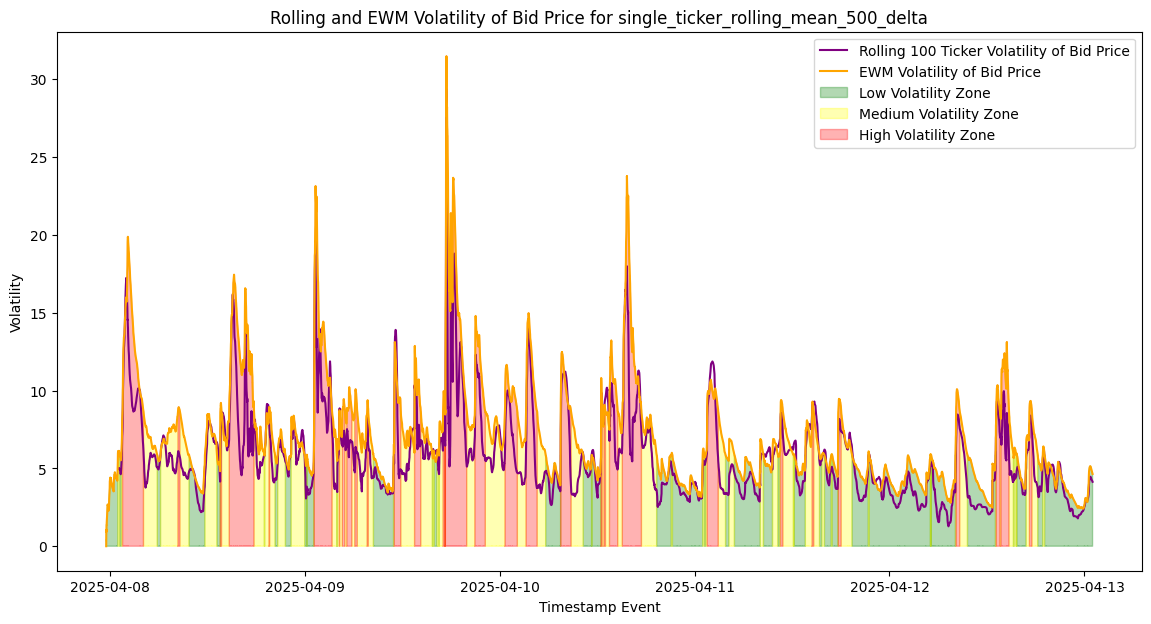

In [14]:
import matplotlib.pyplot as plt

# Calculate the rolling and exponentially weighted moving average (ewm) volatility of bidPrice0
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    # Calculate rolling volatility
    rolling_volatility = output_df['bidPrice0'].rolling(window=20000).std()

    # Calculate exponentially weighted moving average volatility
    ewm_volatility = output_df['bidPrice0'].ewm(span=20000, adjust=False).std()

    # Classify each row into volatility categories based on ewm volatility
    volatility_thresholds = ewm_volatility.quantile([0.33, 0.66])
    output_df['volatility_category'] = pd.cut(
        ewm_volatility,
        bins=[-float('inf'), volatility_thresholds[0.33], volatility_thresholds[0.66], float('inf')],
        labels=['low', 'medium', 'high']
    )

    # Plot the rolling and ewm volatility with zones
    plt.figure(figsize=(14, 7))
    plt.plot(output_df['timestampEvent'], rolling_volatility, label='Rolling 100 Ticker Volatility of Bid Price', color='purple')
    plt.plot(output_df['timestampEvent'], ewm_volatility, label='EWM Volatility of Bid Price', color='orange')

    # Highlight the volatility zones
    plt.fill_between(output_df['timestampEvent'], 0, ewm_volatility, where=output_df['volatility_category'] == 'low', color='green', alpha=0.3, label='Low Volatility Zone')
    plt.fill_between(output_df['timestampEvent'], 0, ewm_volatility, where=output_df['volatility_category'] == 'medium', color='yellow', alpha=0.3, label='Medium Volatility Zone')
    plt.fill_between(output_df['timestampEvent'], 0, ewm_volatility, where=output_df['volatility_category'] == 'high', color='red', alpha=0.3, label='High Volatility Zone')

    plt.xlabel('Timestamp Event')
    plt.ylabel('Volatility')
    plt.title(f'Rolling and EWM Volatility of Bid Price for {action_name}')
    plt.legend()
    plt.show()
    break


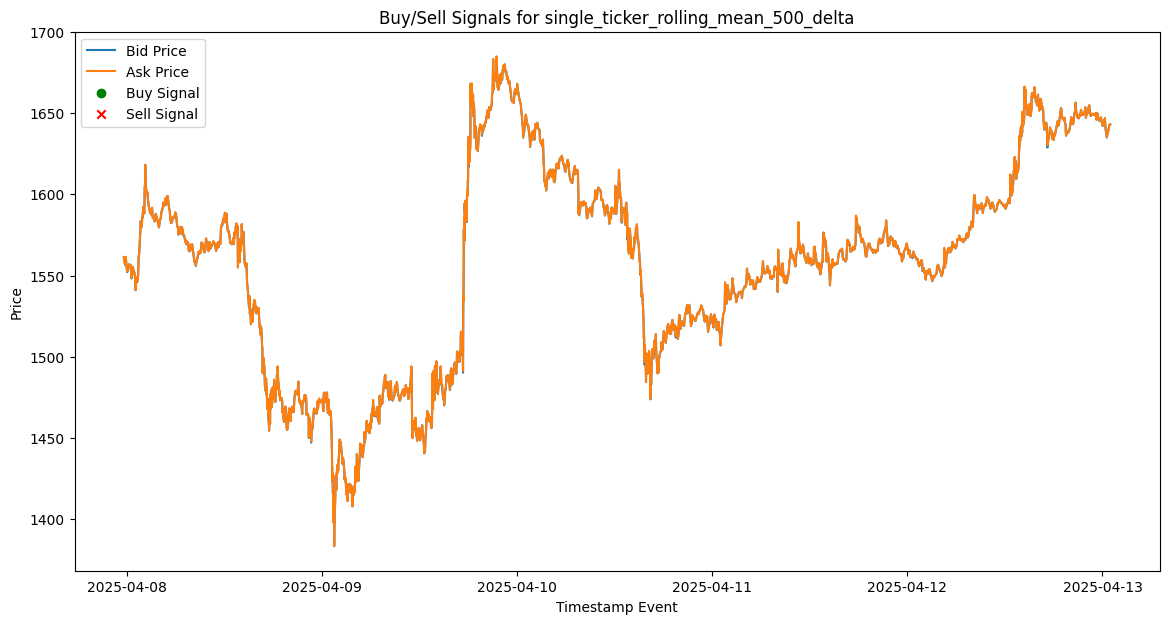

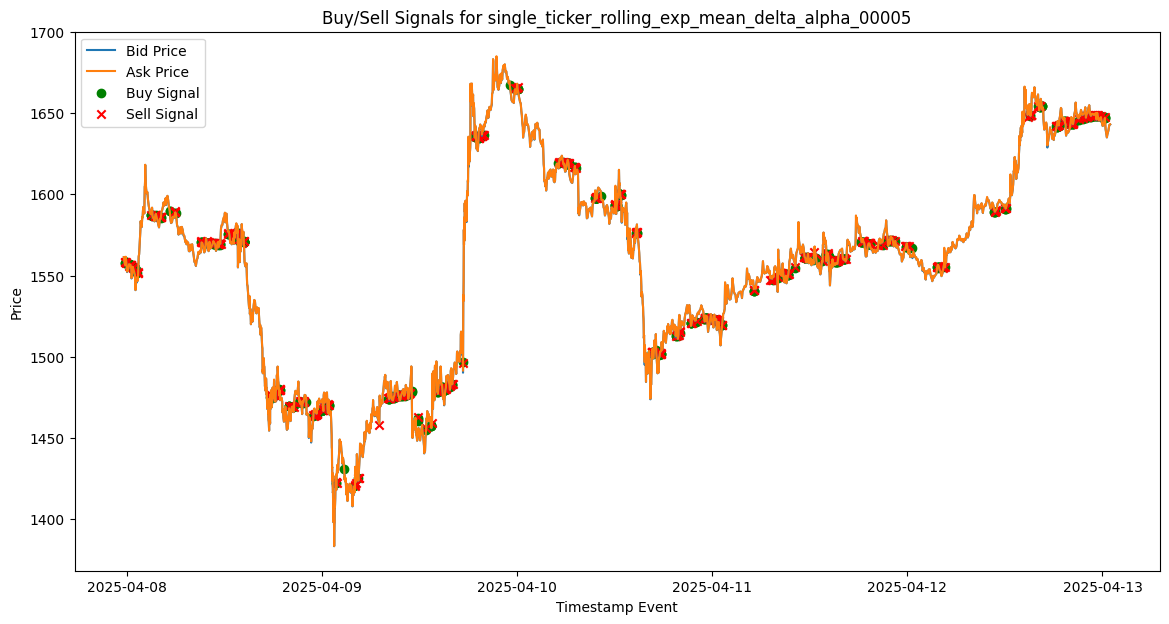

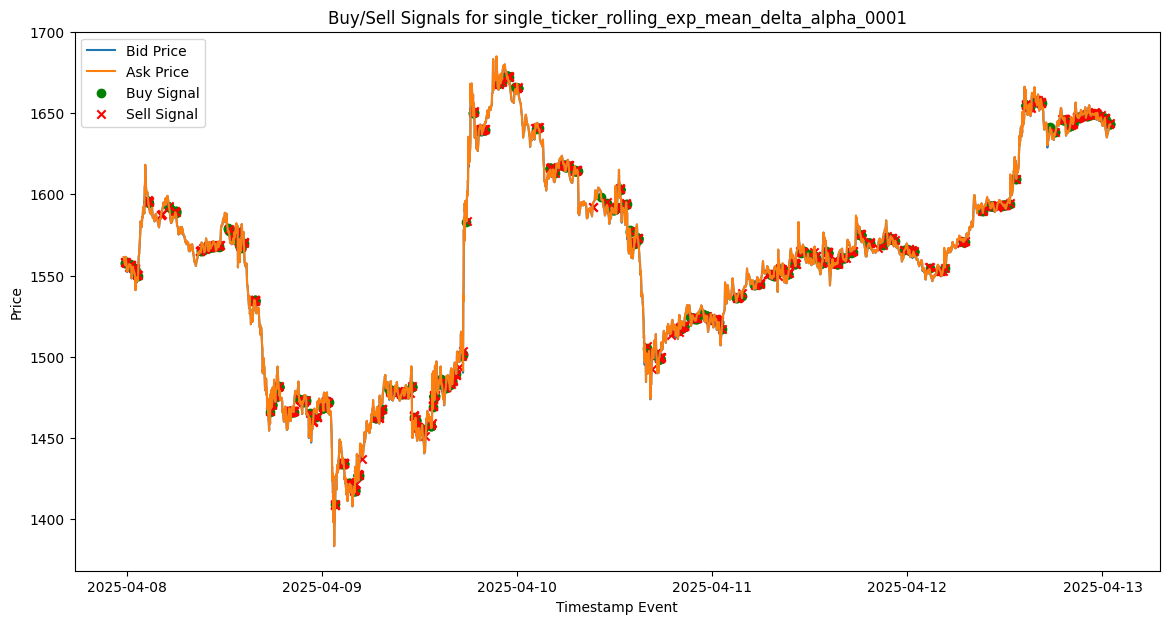

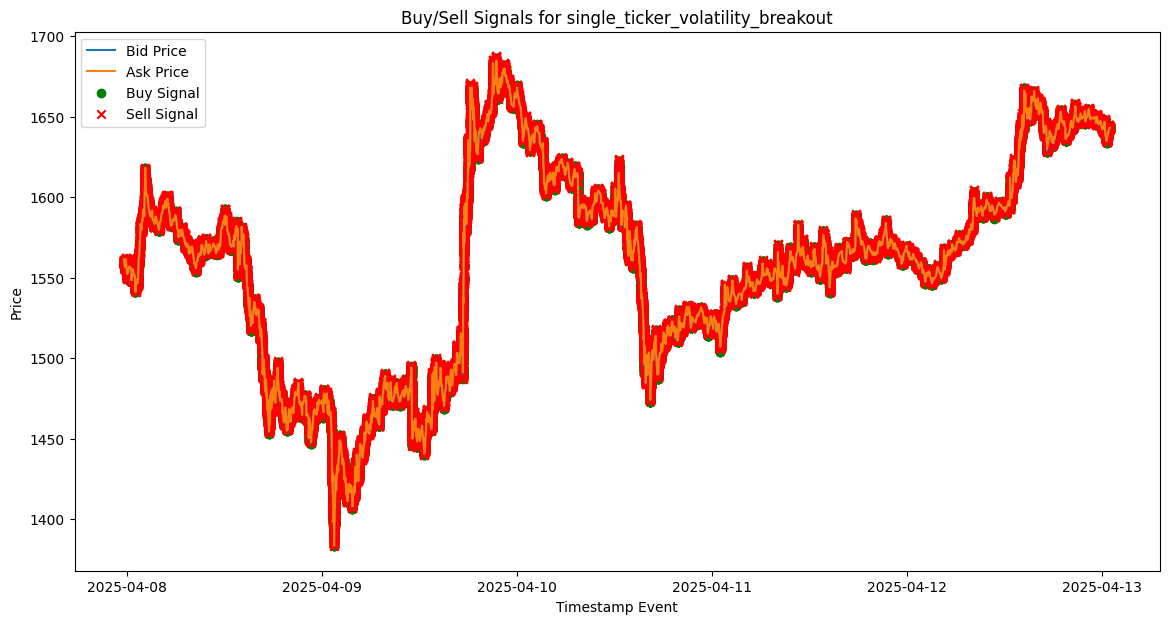

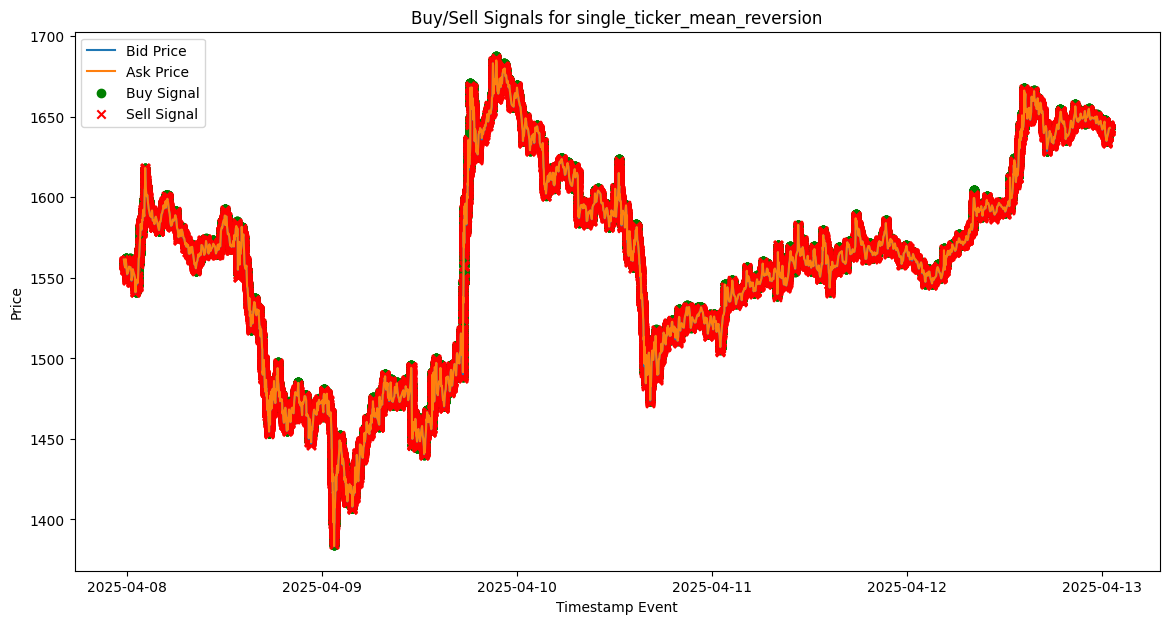

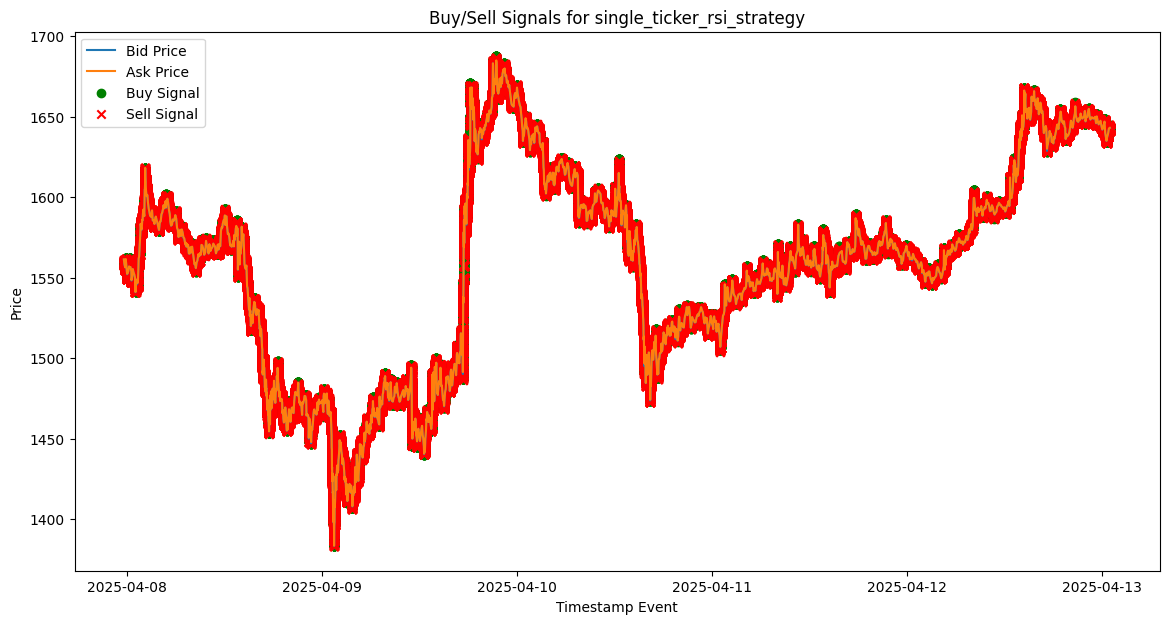

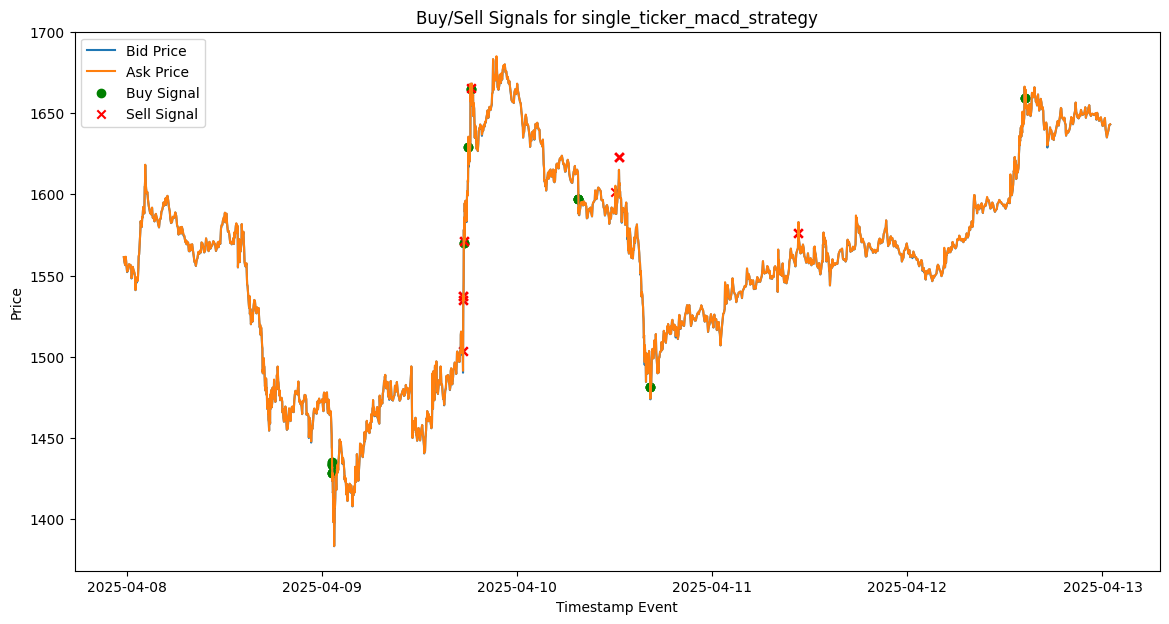

/Users/andrewannetrand/Desktop/gnomepy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


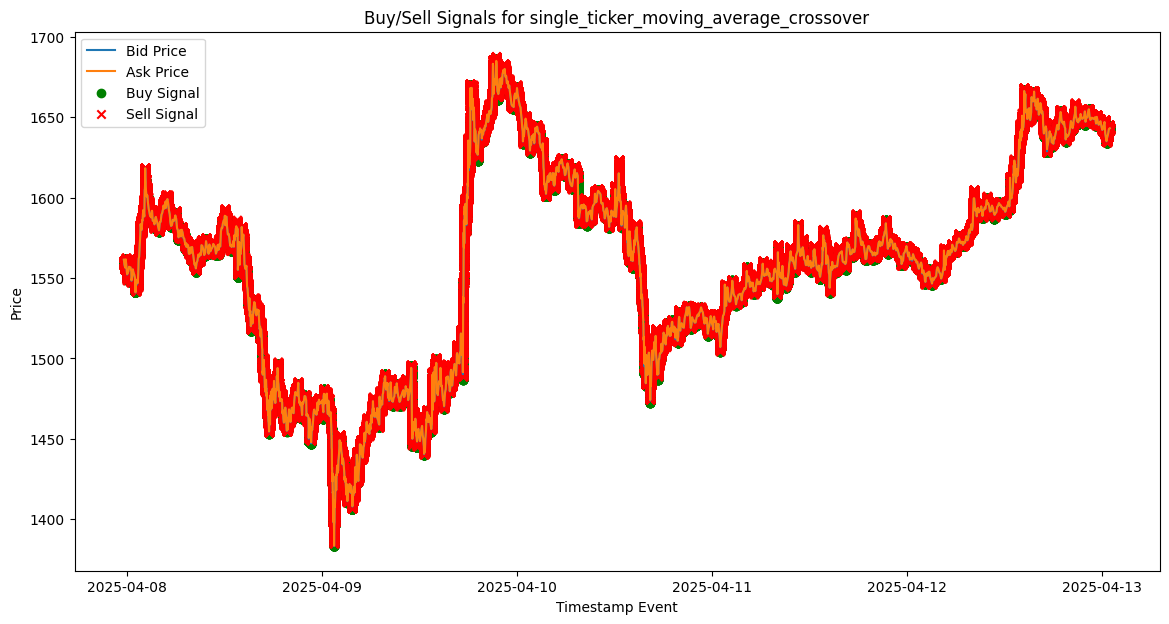

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the plot for buy/sell signals for each strategy
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    # Sample every 1000th row for the current strategy's output
    sampled_df = output_df.iloc[::1000, :]

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=sampled_df, x='timestampEvent', y='bidPrice0', label='Bid Price')
    sns.lineplot(data=sampled_df, x='timestampEvent', y='askPrice0', label='Ask Price')
    plt.xlabel('Timestamp Event')
    plt.ylabel('Price')
    plt.title('Bid and Ask Prices')


    # Add green and red dots for actions specific to each strategy
    buy_signals = output_df[output_df[f'{action_name}_cash_action'] > 0]
    sell_signals = output_df[output_df[f'{action_name}_cash_action'] < 0]

    plt.scatter(buy_signals['timestampEvent'], buy_signals['askPrice0'], color='green', label='Buy Signal', marker='o')
    plt.scatter(sell_signals['timestampEvent'], sell_signals['askPrice0'], color='red', label='Sell Signal', marker='x')

    plt.xlabel('Timestamp Event')
    plt.ylabel('Price')
    plt.title(f'Buy/Sell Signals for {action_name}')
    plt.legend()
    plt.show()


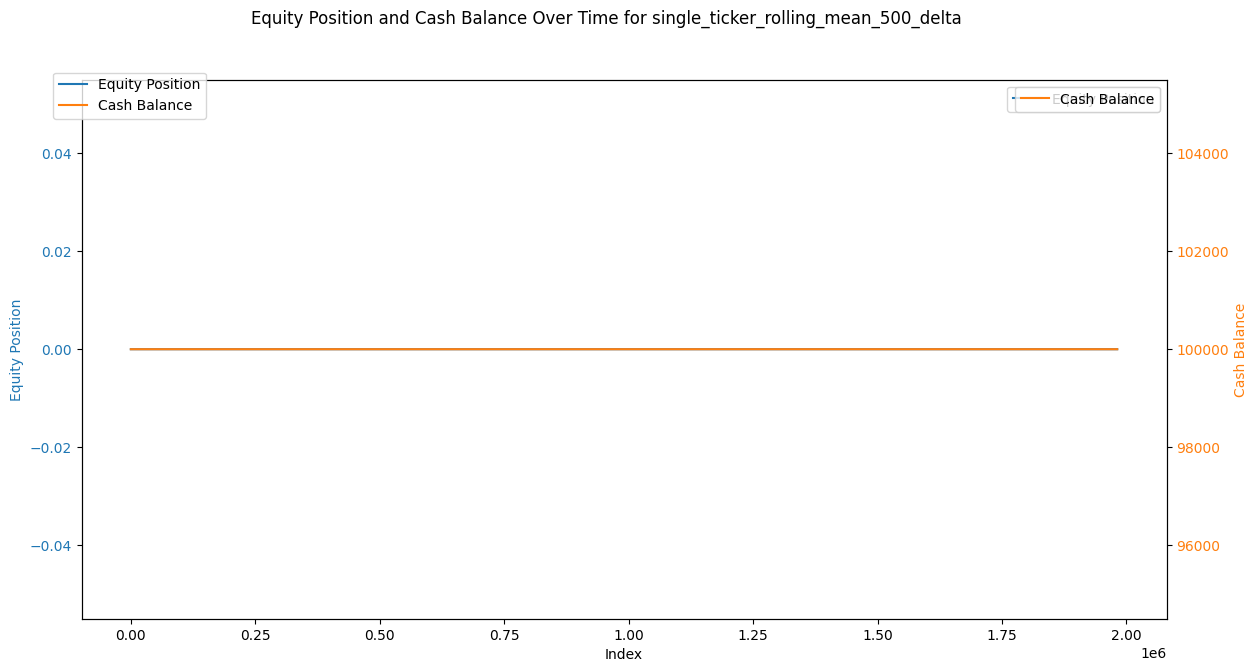

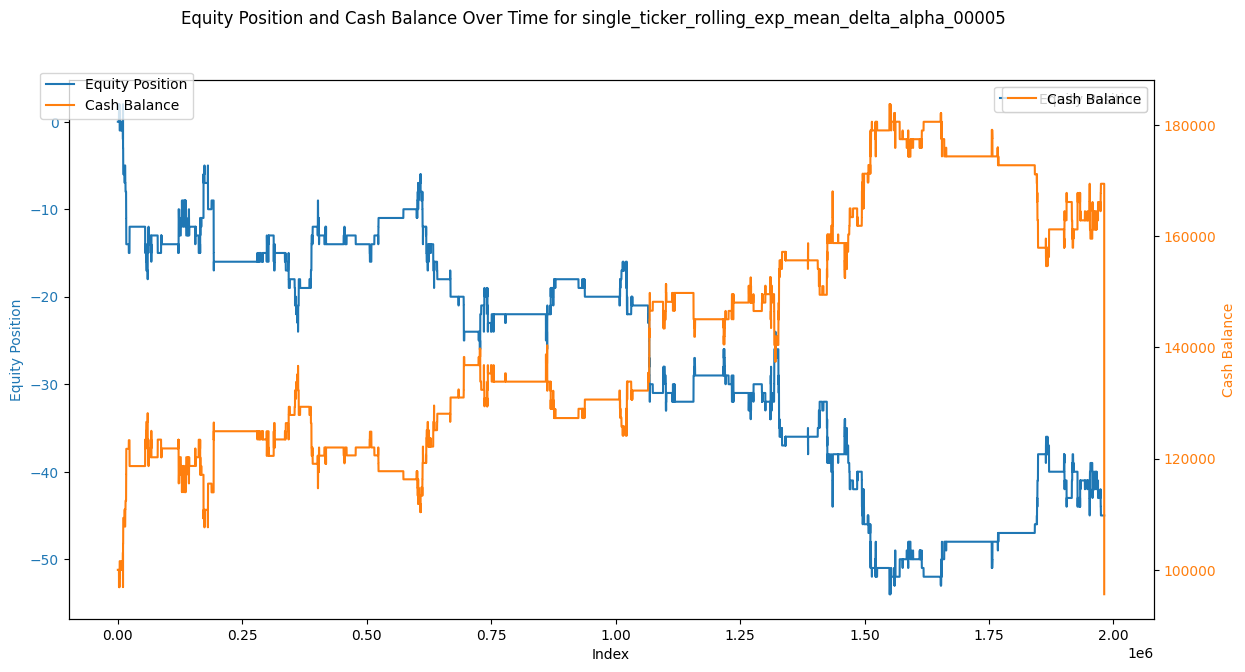

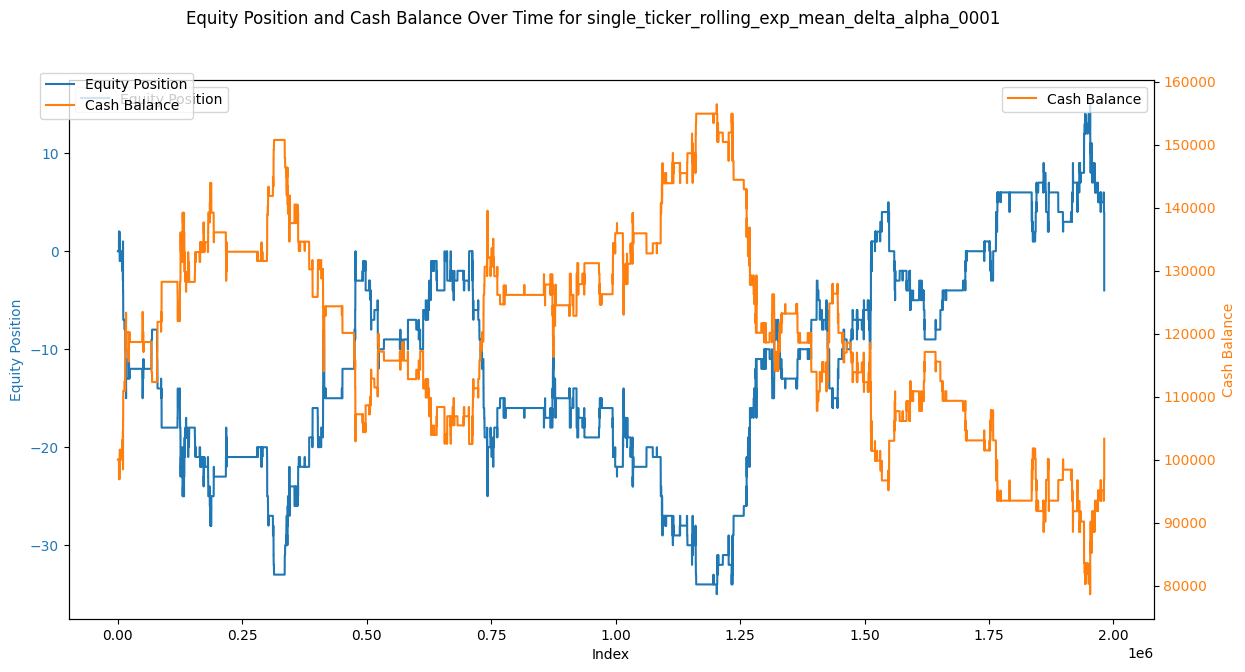

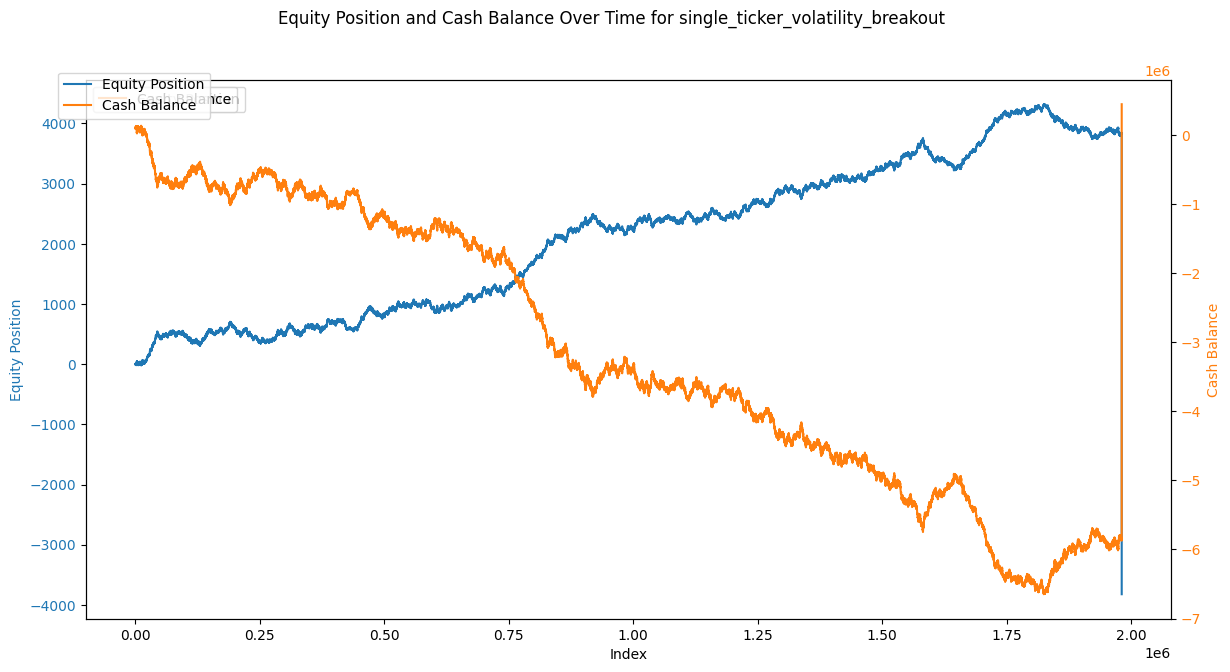

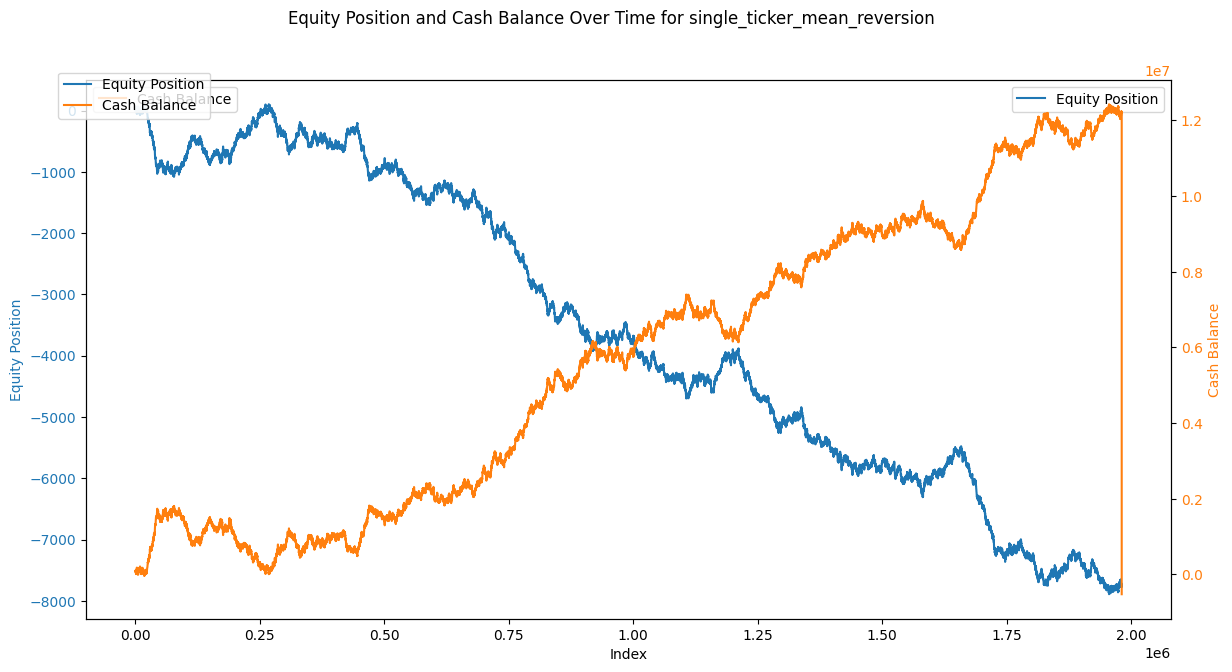

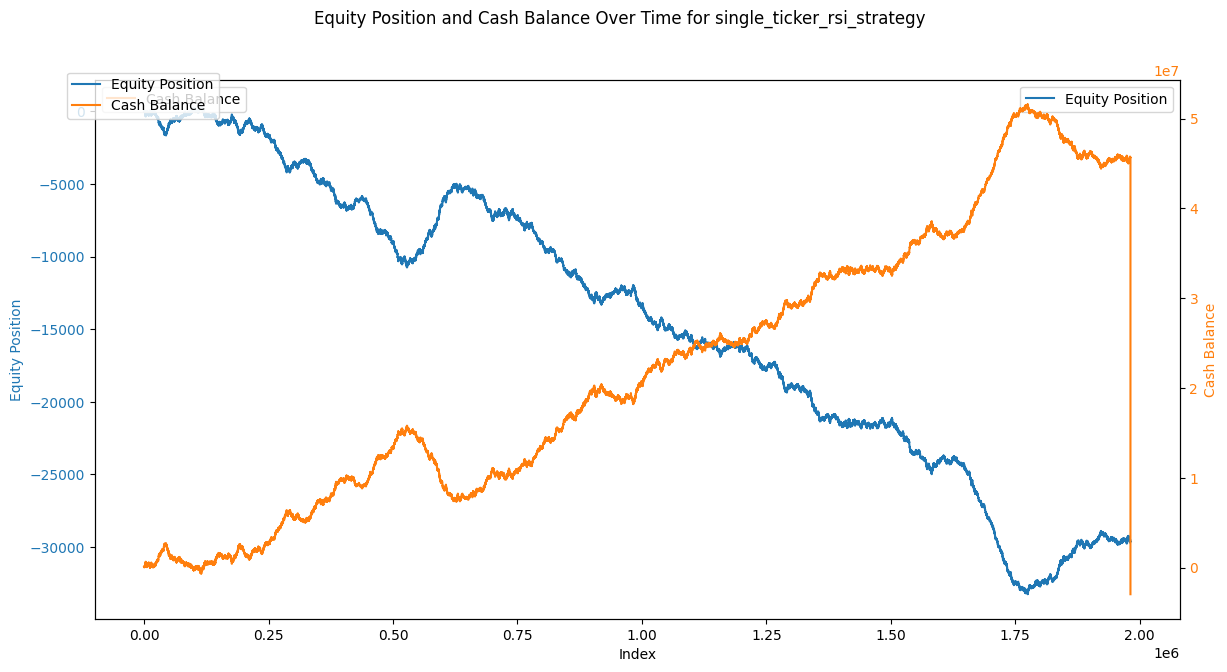

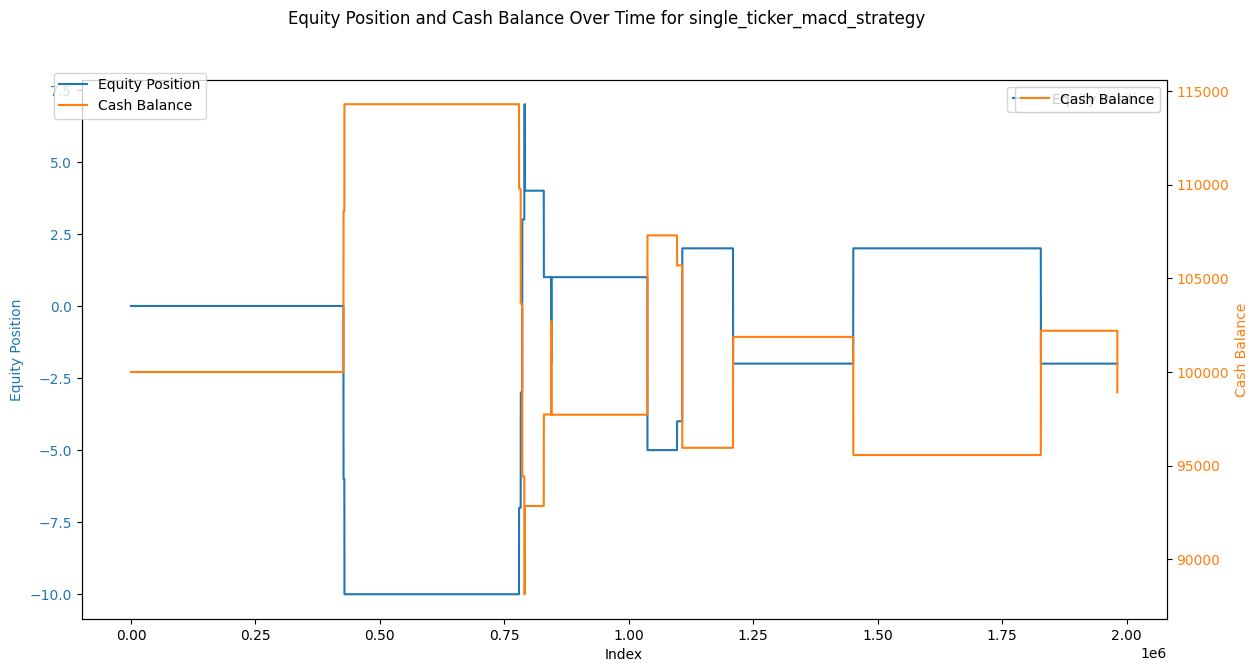

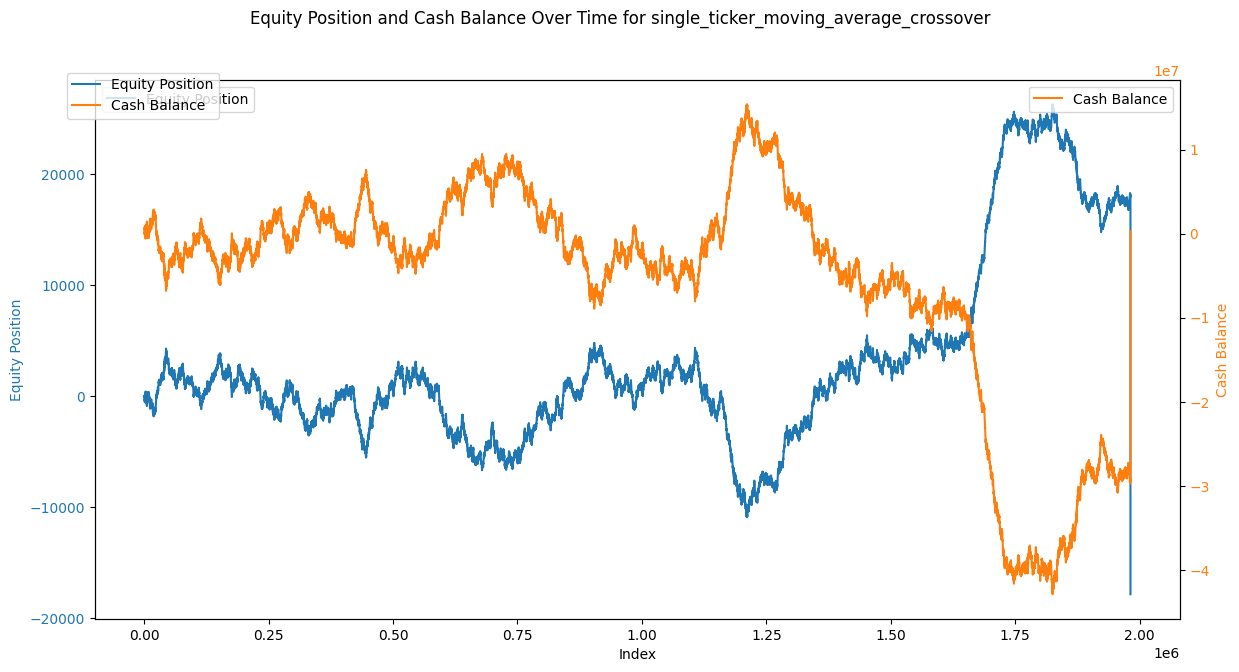

In [5]:
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Equity Position on the first y-axis
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Equity Position', color='tab:blue')
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_equity_position', label='Equity Position', ax=ax1, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for Cash Balance
    ax2 = ax1.twinx()
    ax2.set_ylabel('Cash Balance', color='tab:orange')
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_cash_balance', label='Cash Balance', ax=ax2, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Add title and legend
    fig.suptitle(f'Equity Position and Cash Balance Over Time for {action_name}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

In [ ]:
# Initialize a dictionary to store metrics for each strategy
strategy_metrics = {}

for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    # Classify each row into volatility categories based on ewm volatility
    ewm_volatility = output_df['bidPrice0'].ewm(span=20000, adjust=False).std()
    volatility_thresholds = ewm_volatility.quantile([0.33, 0.66])
    output_df['volatility_category'] = pd.cut(
        ewm_volatility,
        bins=[-float('inf'), volatility_thresholds[0.33], volatility_thresholds[0.66], float('inf')],
        labels=['low', 'medium', 'high']
    )

    # Initialize a dictionary to store metrics for each volatility zone
    strategy_metrics[action_name] = {}

    # Calculate and store advanced HFT metrics for each volatility zone
    for volatility_zone in ['low', 'medium', 'high']:
        zone_df = output_df[output_df['volatility_category'] == volatility_zone]

        # Identify sectors within the volatility zone
        zone_df['sector'] = (zone_df.index.to_series().diff() != 1).cumsum()

        # Calculate metrics at the sector level
        sector_metrics = []
        for sector, sector_df in zone_df.groupby('sector'):
            mean_bid_price = sector_df['bidPrice0'].mean()
            mean_ask_price = sector_df['askPrice0'].mean()
            total_trades = len(sector_df[sector_df[f'{action_name}_cash_action'] != 0])
            profit_factor = (sector_df[f'{action_name}_cash_balance'].iloc[-1] - strategy.starting_cash) / strategy.starting_cash if strategy.starting_cash != 0 else float('inf')
            number_of_buys = len(sector_df[sector_df[f'{action_name}_cash_action'] > 0])
            number_of_sells = len(sector_df[sector_df[f'{action_name}_cash_action'] < 0])

            sector_metrics.append({
                'mean_bid_price': mean_bid_price,
                'mean_ask_price': mean_ask_price,
                'total_trades': total_trades,
                'profit_factor': profit_factor,
                'number_of_buys': number_of_buys,
                'number_of_sells': number_of_sells
            })
        
    
        # Calculate mean and std of the sector metrics at the volatility level
        mean_metrics = {key: np.mean([sector[key] for sector in sector_metrics]) for key in sector_metrics[0]}
        std_metrics = {key: np.std([sector[key] for sector in sector_metrics]) for key in sector_metrics[0]}

        # Store the metrics for each strategy and volatility zone
        strategy_metrics[action_name][volatility_zone] = {
            'mean_metrics': mean_metrics,
            'std_metrics': std_metrics,
            "all_metrics": sector_metrics
        }

# Now strategy_metrics contains all the metrics for each strategy and volatility zone


/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_17092/3536110269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_df['sector'] = (zone_df.index.to_series().diff() != 1).cumsum()
/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_17092/3536110269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_df['sector'] = (zone_df.index.to_series().diff() != 1).cumsum()
/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_17092/3536110269.py:25: SettingWithCopyWarning: 
A value 

In [76]:
profit_factors_df

,Strategy,Volatility,Profit Factor
0,single_ticker_rolling_mean_500_delta,low,0.000000
1,single_ticker_rolling_mean_500_delta,low,0.000000
2,single_ticker_rolling_mean_500_delta,low,0.000000
3,single_ticker_rolling_mean_500_delta,low,0.000000
4,single_ticker_rolling_mean_500_delta,low,0.000000
...,...,...,...
1139,single_ticker_moving_average_crossover,high,1.074084
1140,single_ticker_moving_average_crossover,high,0.910276
1141,single_ticker_moving_average_crossover,high,1.299834
1142,single_ticker_moving_average_crossover,high,1.068640


In [82]:
# Create a DataFrame from strategy_metrics for each strategy and volatility zone
all_metrics_df = pd.DataFrame([
    {
        'Strategy': strategy,
        'Volatility': volatility_zone,
        'Profit Factor': metric['profit_factor']
    }
    for strategy in strategy_metrics
    for volatility_zone in strategy_metrics[strategy]
    for metric in strategy_metrics[strategy][volatility_zone]['all_metrics']
])
all_metrics_df

,Strategy,Volatility,Profit Factor
0,single_ticker_rolling_mean_500_delta,low,0.000000
1,single_ticker_rolling_mean_500_delta,low,0.000000
2,single_ticker_rolling_mean_500_delta,low,0.000000
3,single_ticker_rolling_mean_500_delta,low,0.000000
4,single_ticker_rolling_mean_500_delta,low,0.000000
...,...,...,...
1139,single_ticker_moving_average_crossover,high,-85.728907
1140,single_ticker_moving_average_crossover,high,-400.397885
1141,single_ticker_moving_average_crossover,high,-384.023575
1142,single_ticker_moving_average_crossover,high,-380.721780


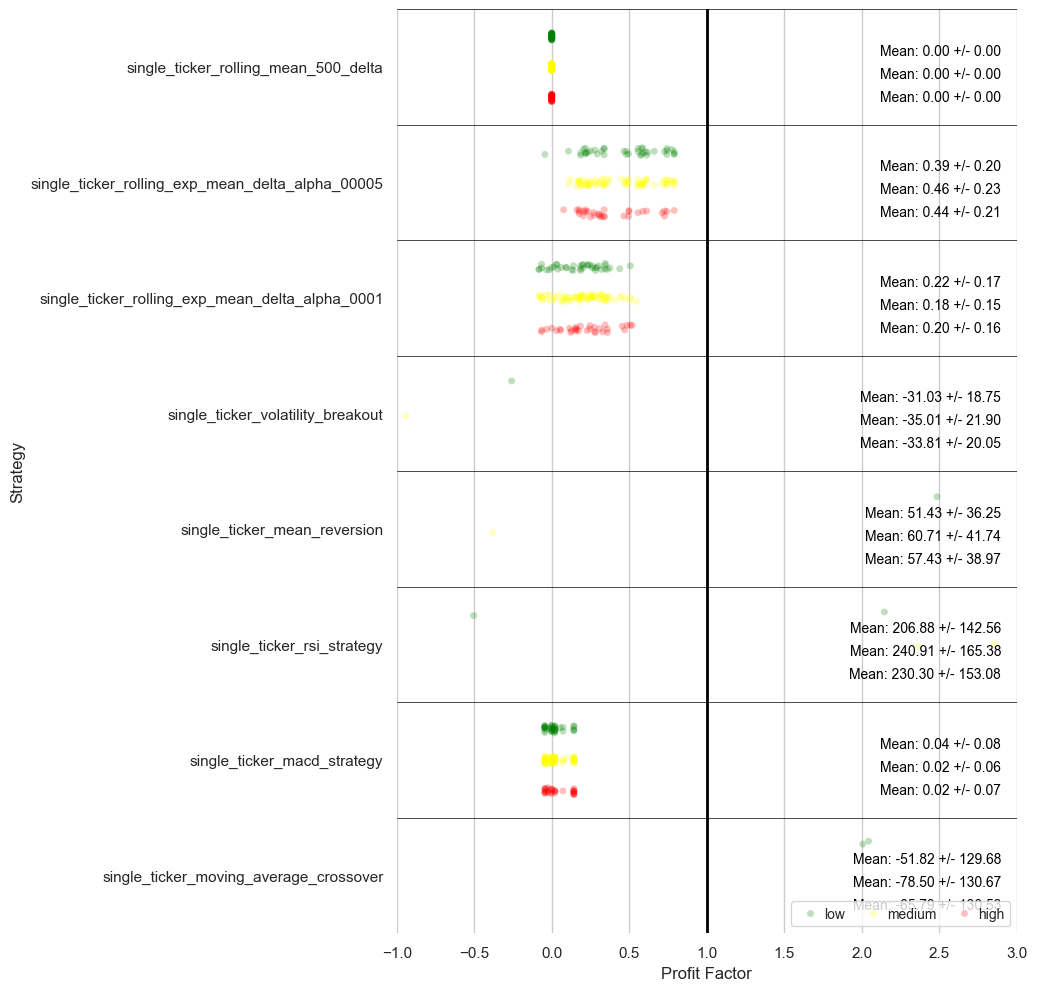

In [83]:
# Build the DataFrame using the mean and std metrics
profit_factors_df = all_metrics_df

# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Initialize the figure with increased height to space strategies more
f, ax = plt.subplots(figsize=(8, 12))  # Adjust the height to space out the strategies
sns.despine(bottom=True, left=True)

# Define a custom palette for volatility levels
custom_palette = {'low': 'green', 'medium': 'yellow', 'high': 'red'}

# Show each observation with a scatterplot
sns.stripplot(
    data=profit_factors_df, x="Profit Factor", y="Strategy", hue="Volatility",
    dodge=True, alpha=.25, zorder=1, palette=custom_palette
)

# Add mean and std as black font labels next to each stripplot for each volatility zone
for i, (strategy, strategy_df) in enumerate(profit_factors_df.groupby('Strategy')):
    # Ensure the subplot's stripplot strategy matches the strategy of the mean being printed
    strategy_index = profit_factors_df['Strategy'].unique().tolist().index(strategy)
    for j, (volatility, volatility_df) in enumerate(strategy_df.groupby('Volatility')):
        strategy_volatility_data = volatility_df['Profit Factor']
        mean = strategy_volatility_data.mean()
        std = strategy_volatility_data.std()
        # Align the text horizontally with the respective volatility zones
        ax.text(2.9, strategy_index + j * 0.2 - 0.2, f'Mean: {mean:.2f} +/- {std:.2f}', color='black', ha='right', va='top', fontsize='small')

# Add a bold black vertical line at 1
ax.axvline(x=1, color='black', linewidth=2, linestyle='-')

# Set the x-axis limits from 0 to 2
ax.set_xlim(-1, 3)

# Add horizontal lines to separate each row
for ytick in range(len(ax.get_yticks()) + 1):
    ax.axhline(y=ytick - 0.5, color='black', linewidth=0.5, linestyle='-')

# Add the legend manually since move_legend requires an existing legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0, fontsize='small')

plt.show()